In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# Classifier Libraries
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

# Other Libraries
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")


# import the COVID-19 feature count matrix with covariates dataset 
fs="\t"
path="/Users/Hp/Downloads/"
data = pd.read_csv(path+"elastnet_new.csv", delimiter=',', quotechar='"', index_col='sample_ID')
data.head()

AATK  ABCA13  ABCA13.1  ABCB1  ABCB4  ABCB5  ABCC10  ABHD16A  \
sample_ID                                                                  
COV16-8_GT     0       0         0      0      0      0       0        0   
COV12-6_GT     0       0         0      0      0      0       0        0   
COV1-1_GT      0       0         0      0      0      0       0        0   
COV6-3_GT      0       0         0      0      0      0       0        0   
COV18-9_GT     1       0         0      0      0      0       0        0   

            ACSF3_1  ADAM12_1  ...  ZFP36L1_2  ZFR  ZNF141  ZNF282  ZNF334  \
sample_ID                      ...                                           
COV16-8_GT        0         0  ...          0    0       0       0       0   
COV12-6_GT        0         0  ...          0    0       0       2       0   
COV1-1_GT         0         0  ...          0    0       0       0       0   
COV6-3_GT         0         0  ...          0    0       0       0       0   
COV18-9_GT        0         0  ...          0    0       0       0       0   

            ZNF479  ZNF728  ZNF77  ZNF786  grouping  
sample_ID                                            
COV16-8_GT       0       0      0       0         1  
COV12-6_GT       0       0      0       0         1  
COV1-1_GT        0       0      0       0         1  
COV6-3_GT        0       0      0       0         1  
COV18-9_GT       0       0      0       0         1  

[5 rows x 765 columns]

#### Exploratory Data Analysis 

Not Severe 67.3 % of the dataset
Severe 32.7 % of the dataset


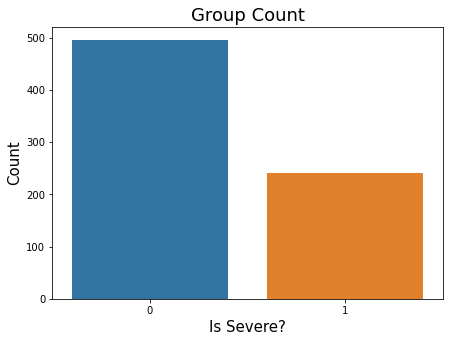

In [2]:
# The classes are heavily skewed we need to solve this issue later.
print('Not Severe', round(data['grouping'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Severe', round(data['grouping'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

plt.figure(figsize=(7,5))
sns.countplot(data['grouping'])
plt.title("Group Count", fontsize=18)
plt.xlabel("Is Severe?", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

This shows some presences of imbalanced class distribution, which we will account for using the SMOTE Resampling approach. 

In [3]:
#Create a pipeline for default Logistic classifier 
pipeline = Pipeline([
    #('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])
pipeline.steps

[('clf', LogisticRegression())]

In [4]:
# Define outcome and predictors to split into train and test groups
# separating the dependent and independent variables
X = data.drop('grouping', 1)
y = data['grouping']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13)

scaler = StandardScaler()

# Oversample severity cases. Imblearn's ADASYN was built for class-imbalanced datasets
#from imblearn.over_sampling import SMOTE, ADASYN
# resample using SMOTE appraoch 
X_bal, y_bal = SMOTE().fit_resample(X_train, y_train)

# Join X and y
X_train = pd.DataFrame(X_bal,columns=X_train.columns)
y_train = pd.DataFrame(y_bal,columns=['grouping'])
balanced = X_bal.join(y_bal)
# Fit only on training set 
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Apply PCA to reduce the dimension of the dataset
#from sklearn.decomposition import PCA
#pca = PCA(.95)
#pca.fit(X_train)
#Apply PCA to both training and test set 
#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

print('-'*40)
print('Data shape after balancing:',balanced.shape)
print('\nCounts of severe VS non-severe in new data:')
print(balanced.grouping.value_counts())

----------------------------------------
Data shape after balancing: (786, 765)

Counts of severe VS non-severe in new data:
1    393
0    393
Name: grouping, dtype: int64


In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(786, 764)
(148, 764)
(786, 1)
(148,)


In [6]:
# define classifiers 
clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(DecisionTreeClassifier())
clfs.append(BalancedRandomForestClassifier())

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
LogisticRegression()
-----------------------------------
fit_time  mean  0.019162321090698244
fit_time  std  0.00790711403473354
score_time  mean  0.0004052162170410156
score_time  std  0.0004963308305687982
test_score  mean  0.9288156091268241
test_score  std  0.03284248626624491
---------------------------------
SVC()
-----------------------------------
fit_time  mean  0.31415705680847167
fit_time  std  0.01299031252784824
score_time  mean  0.07061629295349121
score_time  std  0.003540524371615462
test_score  mean  0.9707812625977585
test_score  std  0.019428246848762133
---------------------------------
DecisionTreeClassifier()
-----------------------------------
fit_time  mean  0.052071762084960935
fit_time  std  0.003956360069032715
score_time  mean  0.0010055065155029296
score_time  std  0.0009012684936354843
test_score  mean  0.7570507135370474
test_score  std  0.06501755806791146
---------------------------------
BalancedRandomForestClassifier(

#### Hyper-parameter tuning 

In [7]:
#SVC classifier 
from sklearn.model_selection import GridSearchCV
pipeline.set_params(clf= SVC())
pipeline.steps

[('clf', SVC())]

In [8]:
cv_grid_svm = GridSearchCV(pipeline, param_grid = {
    'clf__kernel' : ['linear', 'rbf'],
    'clf__C' : np.linspace(0.1,1.2,12)
})

cv_grid_svm.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('clf', SVC())]),
             param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2]),
                         'clf__kernel': ['linear', 'rbf']})

In [9]:
cv_grid_svm.best_params_

{'clf__C': 0.9999999999999999, 'clf__kernel': 'rbf'}

In [10]:
cv_grid_svm.best_estimator_

Pipeline(steps=[('clf', SVC(C=0.9999999999999999))])

In [11]:
cv_grid_svm.best_score_

0.9707812625977585

In [12]:
y_predict_svm = cv_grid_svm.predict(X_test)
accuracy = balanced_accuracy_score(y_test,y_predict_svm)
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy*100))

Accuracy of the best classifier after CV is 94.660%


In [13]:
# AUC and ROC curve SVC classifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
fpr, tpr, _ = roc_curve(y_test, y_predict_svm)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_predict_svm, average=None)
roc_auc

0.9466019417475728


0.9466019417475728

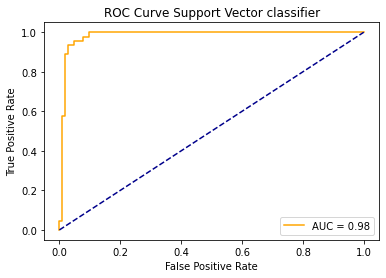

In [14]:
# Now plot the ROC curve for Support Vector Classifier 
probs = cv_grid_svm.decision_function(X_test)
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label = 'AUC = %0.2f' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Support Vector classifier')
    plt.legend()
    plt.show()
    

plot_roc_curve(fpr, tpr)

Test Accuracy 0.9466019417475728
Test F1-score [0.94358974 0.89108911]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       103
           1       0.80      1.00      0.89        45

    accuracy                           0.93       148
   macro avg       0.90      0.95      0.92       148
weighted avg       0.94      0.93      0.93       148



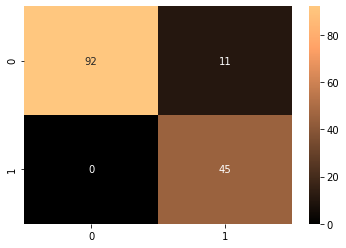

In [15]:
#Classification reports SVC 
print('Test Accuracy %s' % balanced_accuracy_score(y_test, y_predict_svm))
print('Test F1-score %s' % f1_score(y_test, y_predict_svm, average=None))
print(classification_report(y_test, y_predict_svm))
confusion_matrix(y_test, y_predict_svm)
conf_matrix = confusion_matrix(y_test,y_predict_svm)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

#### Logistic Regression classifier 

In [16]:
# Hyper-parameter search for Logistic Regression classifier 

params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1, # Use all CPU
    class_weight={0:0.11,1:1} # Prioritize frauds
)

# Load GridSearchCV
cv_grid_log = GridSearchCV(
    estimator=clf,
    param_grid=params,
    n_jobs=-1,
    scoring=make_scorer(balanced_accuracy_score)
)
cv_grid_log.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight={0: 0.11, 1: 1},
                                          n_jobs=-1),
             n_jobs=-1,
             param_grid=[{'C': [0.3, 0.5, 0.7, 1], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'C': [0.3, 0.5, 0.7, 1], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             scoring=make_scorer(balanced_accuracy_score))

In [17]:
cv_grid_log.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [18]:
cv_grid_log.best_estimator_

LogisticRegression(C=1, class_weight={0: 0.11, 1: 1}, n_jobs=-1,
                   solver='newton-cg')

In [19]:
cv_grid_log.best_score_

0.9249918857513795

In [20]:
y_predict_log = cv_grid_log.predict(X_test)
accuracy = balanced_accuracy_score(y_test,y_predict_log)
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy*100))

Accuracy of the best classifier after CV is 89.385%


In [21]:
# Now plot the ROC curve for Logistic regression 
probs = cv_grid_log.predict_proba(X_test)
probs = probs[:, 1]
auc1 = roc_auc_score(y_test, probs)
fpr1, tpr1, thresholds = roc_curve(y_test, probs)
def plot_roc_curve(fpr1, tpr1):
    plt.plot(fpr1, tpr1, color='orange', label = 'AUC = %0.2f' % auc1)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of Logistic Regression classifier')
    plt.legend()
    plt.show()

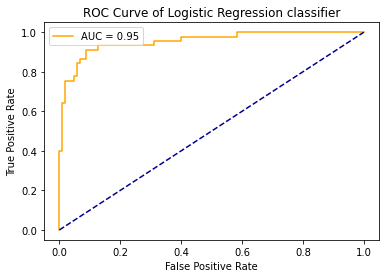

In [22]:
plot_roc_curve(fpr1, tpr1)

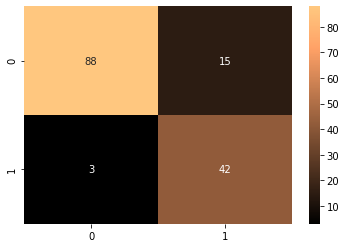

In [23]:
# Print confusion matrix Logistic Classifier 
conf_matrix = confusion_matrix(y_test,y_predict_log)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
    

In [24]:
#Logistic Regression classification Reports 
print('Test Accuracy %s' % balanced_accuracy_score(y_test, y_predict_log))
print('Test F1-score %s' % f1_score(y_test, y_predict_log, average=None))
print(classification_report(y_test, y_predict_log))
confusion_matrix(y_test, y_predict_log)

Test Accuracy 0.8938511326860841
Test F1-score [0.90721649 0.82352941]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       103
           1       0.74      0.93      0.82        45

    accuracy                           0.88       148
   macro avg       0.85      0.89      0.87       148
weighted avg       0.90      0.88      0.88       148



array([[88, 15],
       [ 3, 42]], dtype=int64)

In [25]:
# get importance Logistic regression best on best estimator identified from CV grid search 
clf = LogisticRegression(C=1, class_weight={0: 0.11, 1: 1}, n_jobs=-1, penalty='l1',
                   solver='saga')
clf.fit(X_train, y_train)
#Analyzing the coefficients
importance_logreg = pd.concat([pd.DataFrame(X.columns, columns = ["Features"]),
           pd.DataFrame(np.transpose(clf.coef_), columns = ["Importance"])
           ],axis = 1)
importance_logreg.sort_values(by='Importance', ascending=False).head(10)
#save as CSV file 
#importance_logreg.to_csv("importance_features_LASSO_Logreg_1.csv", index = True)

Features  Importance
52        ATRNL1    0.113447
468       NDUFS1    0.109118
459       NBPF11    0.101280
308        IFI16    0.090019
549        POMT2    0.085213
226       FBXO41    0.073851
74         C4BPB    0.073573
271  GOLGA6L22_9    0.072767
513         PASK    0.071866
554      POTEI_2    0.067676

#### Create a surrogate model for the winner model (SVC)

In [26]:
# saving the predictions of SVC classifier as new target
new_target = cv_grid_svm.predict(X_train)

# defining the interpretable decision tree model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=10)

# fitting the surrogate decision tree model using the training set and new target
dt_model.fit(X_train,new_target)

DecisionTreeClassifier(max_depth=5, random_state=10)

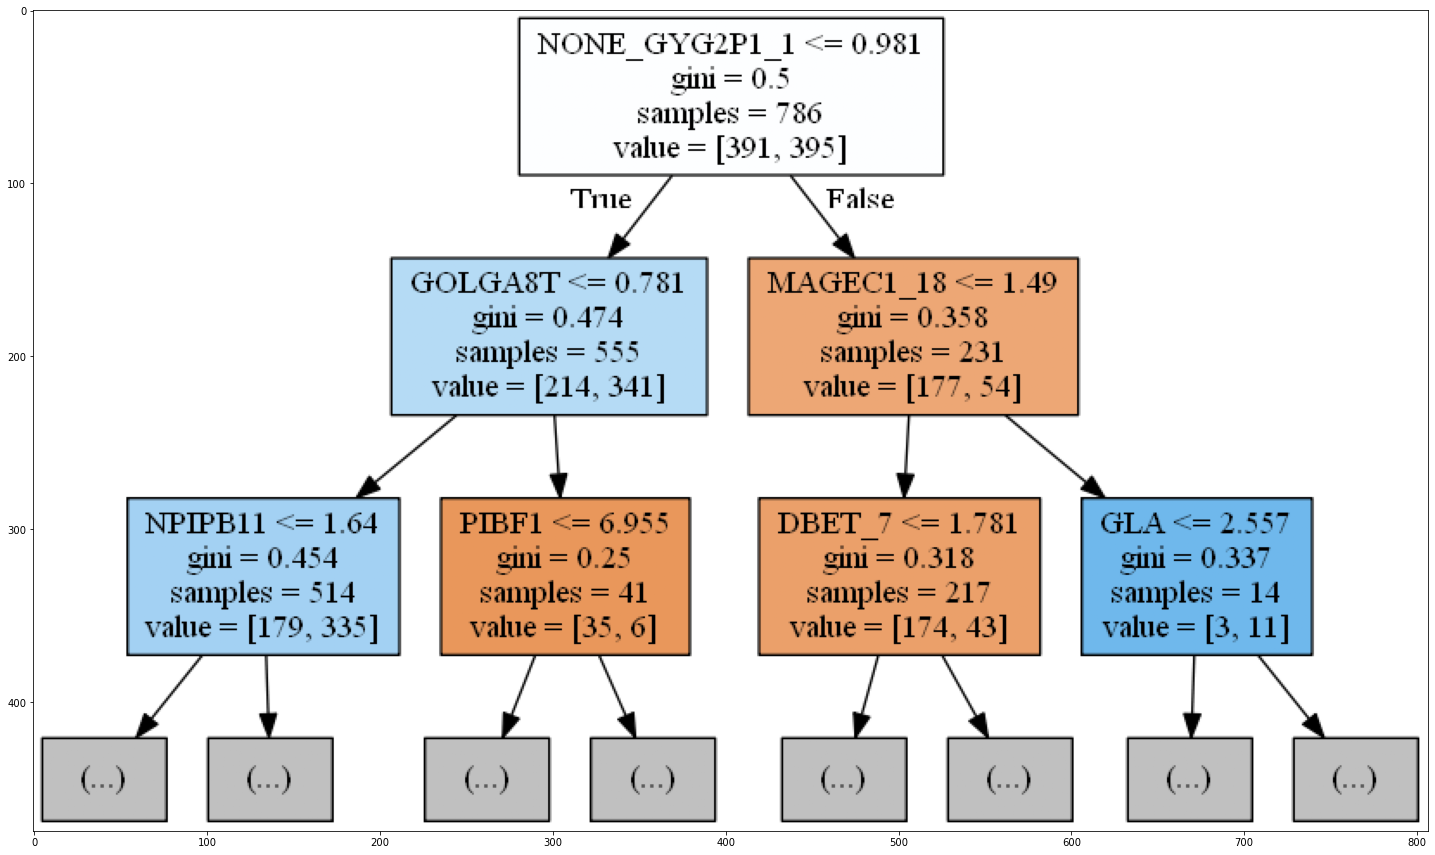

In [27]:
# Visualising the decision tree for SVC classifier 
from sklearn import tree
decision_tree = tree.export_graphviz(dt_model, out_file='tree.dot', feature_names=X.columns, filled=True, max_depth=2)

# converting the dot image to png format
!dot -Tpng tree.dot -o tree.png

#plotting the decision tree
image = plt.imread('tree.png')
plt.figure(figsize=(25,25))
plt.imshow(image)

In [28]:
#Analyzing the coefficients
importance_dt = pd.concat([pd.DataFrame(X.columns, columns = ["Features"]),
           pd.DataFrame(np.transpose(dt_model.feature_importances_), columns = ["Importance"])
           ],axis = 1)
importance_dt.sort_values(by='Importance', ascending=False).head(10)
#save as CSV file 
#importance_dt.to_csv("importance_features_LASSO_decision_tree.csv", index = True)

Features  Importance
474  NONE_GYG2P1_1    0.307794
278        GOLGA8T    0.126320
482        NPIPB11    0.088418
577         RAD23A    0.081930
171         DOK7_1    0.073539
380      MAGEC1_18    0.059130
735          VWA3B    0.032972
145         DBET_7    0.032423
255            GLA    0.030698
435        MUC4_27    0.028756

#### SHAP explanation of Global SVC model 

In [29]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [30]:
# create a train/test split using the prediction from SVC model 
X_train, X_test, y_train, y_test = train_test_split(X_train, new_target, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

#### Train XGBoost model

In [31]:
params = {
    "eta": 0.002,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 50000, evals = [(d_test, "test")], verbose_eval=1000, early_stopping_rounds=20)

[0]	test-logloss:0.69689
Will train until test-logloss hasn't improved in 20 rounds.
[1000]	test-logloss:0.44850
[2000]	test-logloss:0.35892
[3000]	test-logloss:0.30979
[4000]	test-logloss:0.27748
[5000]	test-logloss:0.25405
[6000]	test-logloss:0.23576
[7000]	test-logloss:0.22104
[8000]	test-logloss:0.21118
[9000]	test-logloss:0.20460
Stopping. Best iteration:
[9263]	test-logloss:0.20348



##### Classic feature attributions
Here we adopt the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates us to use SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

In [32]:
#xgboost.plot_importance(model)
#pl.title("xgboost.plot_importance(model)")
#pl.show()

In [33]:
#Assessing feature importance 
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=100)
xgboost.fit(X_train, y_train)
importance_xgboost = pd.concat([pd.DataFrame(X.columns, columns = ["Features"]),
           pd.DataFrame(np.transpose(xgboost.feature_importances_), columns = ["Importance"])
           ],axis = 1)
importance_xgboost.sort_values(by='Importance', ascending=False).head(10)


Features  Importance
706         TUBA1C    0.028810
356         LMAN1L    0.026952
474  NONE_GYG2P1_1    0.025232
145         DBET_7    0.022073
662           TFAM    0.019518
46            ASS1    0.017046
634         SPPL2A    0.016152
404            MGA    0.015879
657         TDRD12    0.014844
278        GOLGA8T    0.014248

In [34]:
#save as CSV file 
#importance_xgboost.to_csv("importance_features_lasso_xgboost_1.csv", index = True)

#### Explainabel feature predictions
Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset 

In [35]:
# this takes a minute or two since we are explaining over 32 features in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

##### Visualize a single prediction
Here we tried to use the "display values" data frame in order to display nice strings instead of category codes.

In [36]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:], X.columns)

In [37]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:], X.columns)

##### Visualize many predictions
To keep the browser happy we only visualize 100 individuals.

In [38]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train[:100,:], X.columns)

#### SHAP Summary Plot
Instead of adopting the use of normal feature importance bar chart, the density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for single features in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of the individual.

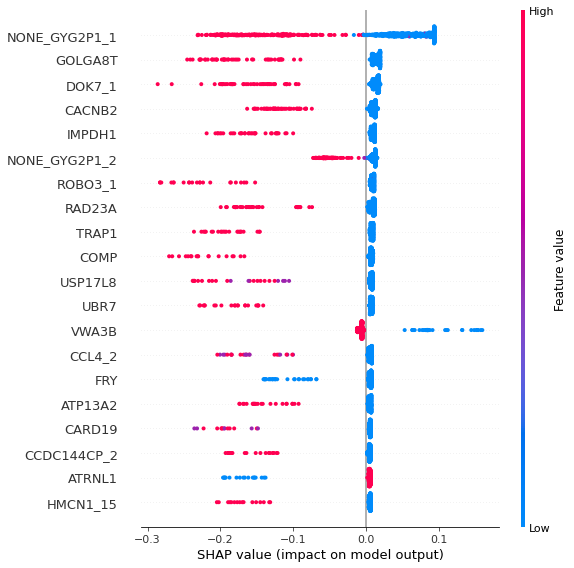

In [39]:
# summary on the train set 
shap.summary_plot(shap_values, X_train, X.columns)

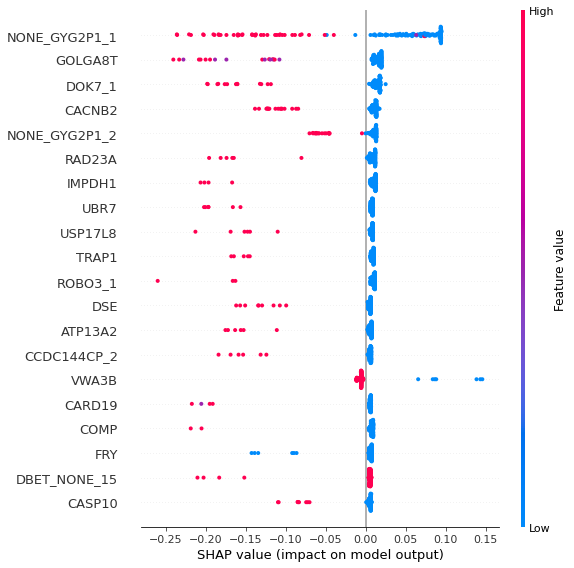

In [40]:
shap_values = explainer.shap_values(X_test)
# summary on the train set 
shap.summary_plot(shap_values, X_test, X.columns)